In [16]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path :
    sys.path.append(module_path)

    
import _ressources.chain as chain
import _ressources.tools as tools
import _ressources.lumenclass as lc
import _ressources.analysis_tools.analysis as an

from scipy.optimize import curve_fit

main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/hydraulic/distribution/'

theta=np.pi/3.
mu = np.sin(theta)**2 / (2*theta - np.sin(2*theta))


In [2]:
nsim = 20
Nt = {}
for i in range(nsim) :
    Nt[i] = np.loadtxt(os.path.join(main_dir, 'run'+str(i).zfill(4), 'sim_nlum.dat'))
    

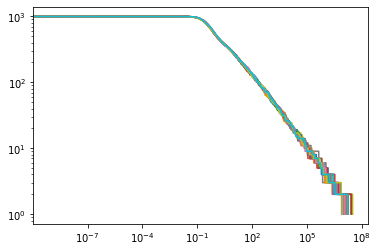

In [3]:
plt.xscale('log')
plt.yscale('log')
for i in range(nsim) :
    plt.plot(Nt[i][:, 0], Nt[i][:, 1])
    

In [4]:
def gen_log_times(tmin, tmax, npts) :
    return np.logspace(np.log10(tmin), np.log10(tmax), npts)

def find_argmins(Nt, log_times) :
    index_array = np.zeros(len(log_times), dtype=int)
    for k in range(len(log_times)) :
        index_array[k] = np.argmin(np.abs(log_times[k]-Nt[:, 0]))
    return index_array

def gen_index_array(Nt, npts) :
    size = len(Nt)
    
    tmin = np.min(Nt[1:, 0])   # skip the first time since t=0
    tmax = np.max(Nt[1:, 0])   # skip the first time since t=0
    
    log_times = gen_log_times(tmin, tmax, npts)
    index_array = find_argmins(Nt, log_times)
    
    return index_array

In [17]:
def find_tstep(time_list, t0) :
    return np.argmin(np.abs(time_list - t0))

def calc_avg_distrib(X_dict, Y_dict) :
    X_array = np.array([X_dict[k] for k in X_dict.keys()])
    X_avg = np.average(X_array, axis=0)

    Y_array = np.array([Y_dict[k] for k in Y_dict.keys()])
    Y_avg = np.average(Y_array, axis=0)
    return X_avg, Y_avg



def make_T_dict(folder, npts, nsim=20, log_tmin=-3, log_tmax=7) :
    time_plot_list = np.logspace(log_tmin, log_tmax, npts)
    T_dict = {}
    #for k in [30] :
    for k in range(nsim) :
        k+=20
        T_dict[k] = np.loadtxt(os.path.join(folder, 'run'+str(k).zfill(4)+'/distrib_length.dat'), usecols=0)
    return T_dict, time_plot_list

def make_step_dict(T_dict, time_plot_list, npts, nsim) :
    step_dict = {}
    for n in range(npts) :
        step_dict[n] = {}
        for k in range(nsim) :
        #for k in [30] :
            k+=20
            step_dict[n][k] = np.argmin(np.abs(T_dict[k] - time_plot_list[n]))
    return step_dict

def calc_distrib(time, folder, area=False) :
    global mu
    dat = {}
    for elem in os.listdir(folder) :
        if elem.startswith('run') :
            print(elem, ' imported', end='\r')
            tdat = np.loadtxt(os.path.join(folder, elem, 'distrib_length.dat'), usecols=0)
            step = np.argmin(np.abs(tdat-time))
            Ldat = np.genfromtxt(os.path.join(folder, elem, 'distrib_length.dat'), skip_header=step, skip_footer=len(tdat)-step-1)
            dat[int(elem[-4:])] = [step, Ldat]
            
    new_L = np.concatenate([dat[k][1][1:] for k in dat.keys()])
    new_A = new_L**2 / mu
    bins = np.max([10, 10+int(np.log10(len(new_L)))*10])
    #bins=20
    if area :
        y, x = np.histogram(new_A, bins=bins, weights=np.ones_like(new_A)/len(new_A))
    else :
        y, x = np.histogram(new_L, bins=bins, weights=np.ones_like(new_L)/len(new_L))
    x = 0.5*(x[1:]+x[:-1])
    distrib = [x, y]
    return distrib



End of import !


(1e-08, 100000000.0)

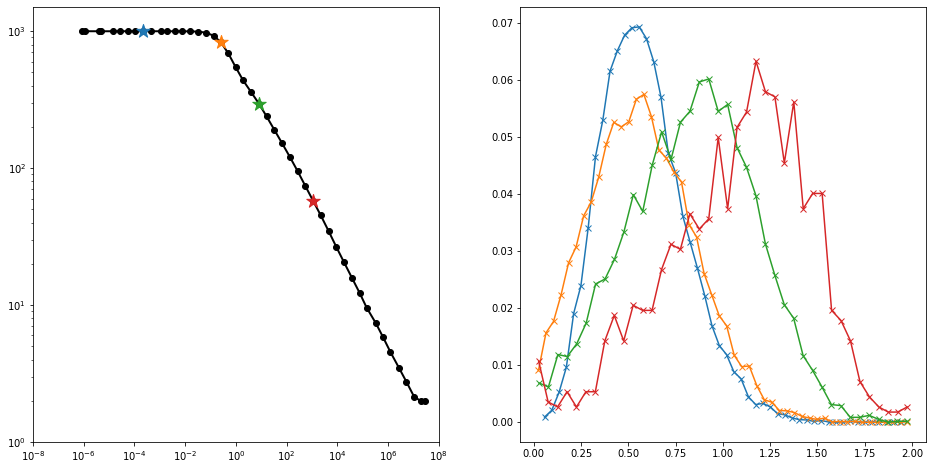

In [27]:
wmin, wmax = -7, 8
npts = 50

#steps = [10, 20, 27, 30]
steps = [10, 20, 25, 32]
#col_steps = {steps[0] : '#800000', steps[1] : '#00cccc', steps[2] : '#808080', steps[3] : '#00ff00', steps[4] : '#F27FBE'}

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].set_xscale('log')
ax[0].set_yscale('log')

folder = os.path.join(main_dir)

index_array = gen_index_array(Nt[0], npts)
res_avg, res_std = an.batch(data_dict=Nt, wmin=wmin, wmax=wmax, nwindow=npts)

for s in steps :
    ax[0].scatter(res_avg[s, 0], res_avg[s, 1], zorder=10, marker='*', s=200)
    if os.path.isfile(os.path.join(main_dir, 'distrib_step'+str(s)+'.txt')) :
        distrib = np.loadtxt(os.path.join(main_dir, 'distrib_step'+str(s)+'.txt'))
    else :
        print('Calculating distribution at step ', s, end='\r')
        distrib = calc_distrib(time = res_avg[s, 0], folder=folder, area=True)
        np.savetxt(os.path.join(main_dir, 'distrib_step'+str(s)+'.txt'), distrib)
    ax[1].plot(distrib[0]/np.average(distrib[0]), distrib[1], label='t = ' +"{:2.2e}".format(res_avg[s, 0]), marker='x')
    

ax[0].plot(res_avg[:, 0], res_avg[:, 1], marker='o', linewidth=2, color='k')
ax[0].set_ylim(1., 1.5e3)
ax[0].set_xlim(1e-8, 1e8)

#ax[1].legend()


#plt.savefig('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/pumping_distributions.eps', format='eps')



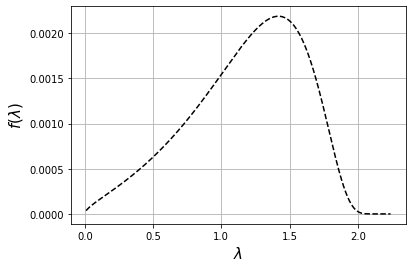

In [51]:
def h(z, C=-4, zmax=2.) :
    return (3+C/(z**2))/(C*(1/z - 1.) - z)
    
def g(z, C=27./10, zmax=9./4) :
    return (5*C - 8*z**(3./2))/(4*z**(5./2) + 10*C*z*(1-np.sqrt(z)))

def calc_fz1(z, dz, z0=1e-6) :    
    sol = [z0]
    for i in range(1, len(z)) :
        sol += [sol[i-1] + dz*h(z[i-1])*sol[i-1]]
    
    Z = np.sum(sol)
    sol = np.array(sol) / Z
    return sol

def calc_fz2(z, dz, z0=1e-6) :    
    sol2 = [z0]
    for i in range(1, len(z)) :
        sol2 += [sol2[i-1] + dz*g(z[i-1])*sol2[i-1]]
    
    Z = np.sum(sol2)
    sol2 = np.array(sol2) / Z
    return sol2

z = np.linspace(0.01, 9./4.-1e-2, 1000)
dz = z[1]-z[0]
#sol = calc_fz1(z, dz)
sol2 = calc_fz2(z, dz)
gamma = 1./np.sum(z*sol)

#plt.plot(z, sol, color='k')
plt.plot(z, sol2, color='k', linestyle='--')
plt.grid()
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel(r'$f(\lambda)$', fontsize=15)
#plt.savefig('/Users/mathieuleverge/Dropbox/M.Leverge/Lumen/Hydro-osmotic coarsening/Theory/figures/chap_hydraulic/self_similar_distribution.eps', format='eps')
plt.show()

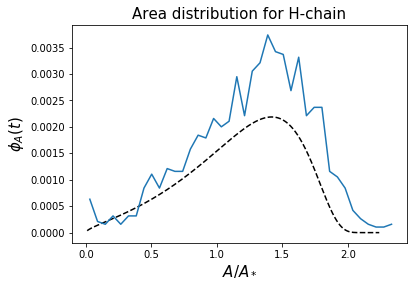

In [59]:
gamma = 0.846

#plt.plot(z, sol/np.max(sol), color='k', label='Analytical')

#plt.plot(z, sol2/np.max(sol2), color='k', linestyle='--')
plt.plot(z, sol2, color='k', linestyle='--')
for s in [32] :
    dat = np.loadtxt(os.path.join(main_dir, 'distrib_step'+str(s)+'.txt'))
    dat_x = dat[0]/(np.average(dat[0])*gamma)
    dx = (dat_x[1]-dat_x[0])
    plt.plot(dat_x, dx*dat[1], label='H-chain')
    
plt.xlabel(r'$A/A_*$', fontsize=15)
plt.ylabel(r'$\phi_A(t)$', fontsize=15)
plt.title('Area distribution for H-chain', fontsize=15)
#plt.savefig('/Users/mathieuleverge/Documents/cavidoc/hydraulic/distribution.eps', format='eps')
plt.show()

In [54]:
dat[0]

array([ 0.71732561,  2.11738323,  3.51744085,  4.91749846,  6.31755608,
        7.7176137 ,  9.11767132, 10.51772894, 11.91778655, 13.31784417,
       14.71790179, 16.11795941, 17.51801703, 18.91807464, 20.31813226,
       21.71818988, 23.1182475 , 24.51830511, 25.91836273, 27.31842035,
       28.71847797, 30.11853559, 31.5185932 , 32.91865082, 34.31870844,
       35.71876606, 37.11882368, 38.51888129, 39.91893891, 41.31899653,
       42.71905415, 44.11911176, 45.51916938, 46.919227  , 48.31928462,
       49.71934224, 51.11939985, 52.51945747, 53.91951509, 55.31957271])

In [8]:
x = np.arange(0., 10.)

In [10]:
x*x

array([ 0.,  1.,  4.,  9., 16., 25., 36., 49., 64., 81.])